# CS 5228


In [1]:
# All Imports
import pandas as pd
import locale
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
locale.setlocale(locale.LC_ALL,'')
pd.set_option('display.max_columns', None)

df_train = pd.read_csv("dataset/Xtrain.csv",dtype= {'Zip': 'object', 'NAICS':'object', 'NewExist':'object', 'FranchiseCode':'object', 'UrbanRural':'object'}, parse_dates=['ApprovalDate','DisbursementDate'])
y_train = pd.read_csv("dataset/Ytrain.csv")
df_train = pd.concat([df_train, y_train['ChargeOff']], axis = 1)

def data_preprocessing(df):
    
    # Drop column
    df = df.drop(columns=['BalanceGross'])

    # Process Date
    df.loc[(df['ApprovalDate'].dt.year >=2020), 'ApprovalDate'] = df['ApprovalDate'] - pd.DateOffset(years=100)
    df.loc[(df['DisbursementDate'].dt.year >=2020), 'DisbursementDate'] = df['DisbursementDate'] - pd.DateOffset(years=100)

    # Process categorical columns for NaN
    df.loc[(df['NewExist'] != "1.0") & (df['NewExist'] != "2.0"), 'NewExist'] = np.NaN
    df['NewExist'] = df['NewExist'].str.strip('.0')

    df.loc[(df['FranchiseCode']=='0') | (df['FranchiseCode']=='1'), 'FranchiseCode'] = '0'
    df.loc[(df['RevLineCr']!='Y'), 'RevLineCr'] = 'N'
    df.loc[(df['LowDoc']!='Y') & (df['LowDoc']!='N'), 'LowDoc'] = np.NaN

    # Process Numeric 
    df['DisbursementGross']= pd.to_numeric(df['DisbursementGross'].map(lambda x: locale.atof(x.strip('$').replace(',','').replace(' ',''))),downcast='float')
    df['GrAppv']= pd.to_numeric(df['GrAppv'].map(lambda x: locale.atof(x.strip('$').replace(',','').replace(' ',''))),downcast='float')
    df['SBA_Appv']= pd.to_numeric(df['SBA_Appv'].map(lambda x: locale.atof(x.strip('$').replace(',','').replace(' ',''))),downcast='float')
    df['ApprovalFY'] = df.ApprovalFY.str.replace(r"\D",'')
    df['ApprovalFY']= pd.to_numeric(df['ApprovalFY'],downcast='integer')
    df['NAICS'] = df.NAICS.str.replace(r"\D",'')
    df['NAICS']= pd.to_numeric(df['NAICS'],downcast='integer')
    df['Zip'] = df.Zip.str.replace(r"\D",'')
    df['Zip']= pd.to_numeric(df['Zip'],downcast='integer')
    df['FranchiseCode'] = df.FranchiseCode.str.replace(r"\D",'')
    df['FranchiseCode']= pd.to_numeric(df['FranchiseCode'],downcast='integer')
    
    return df

def one_hot_encoding_common(df):
    NewExist_dummy = pd.get_dummies(df['NewExist'], prefix='NewExist')
    UrbanRural_dummy = pd.get_dummies(df['UrbanRural'], prefix='UrbanRural')
    RevLineCr_dummy = pd.get_dummies(df['RevLineCr'], prefix='RevLineCr')
    LowDoc_dummy = pd.get_dummies(df['LowDoc'], prefix='LowDoc')

    df = pd.concat([df, NewExist_dummy, UrbanRural_dummy, RevLineCr_dummy, LowDoc_dummy], axis = 1)
    df = df.drop(['NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc', "Id"], axis=1)
    
    return df


def feature_transformation(df_in):
    df_feature = df_in.copy()
    inf = float('inf')
    df_feature.NoEmp = pd.cut(df_feature.NoEmp, bins=[-inf, 9.99, 49.99, 249.99, inf], labels=['Micro', 'Small', 'Medium', 'Large'])
    df_feature.Term = pd.cut(df_feature.Term, bins=[-inf, 0.99*12, 2.99*12, 24.99*12, inf], labels=['Short', 'Intermediate', 'Long', 'Extra Long'])   
    return pd.get_dummies(df_feature, columns=['NoEmp', 'Term'])


print("Training data size before removing duplicate:", df_train.shape)
df_train = df_train.drop_duplicates(subset=df_train.columns.difference(['Id']))
print("Training data size after removing duplicate:", df_train.shape)

df1 = data_preprocessing(df_train)
df2 = df1.dropna()
df3 = df1.fillna(-1)

base_dropna = one_hot_encoding_common(df2)
base_fillna = one_hot_encoding_common(df3)
feature_dropna = feature_transformation(base_dropna)
feature_fillna = feature_transformation(base_fillna)

Training data size before removing duplicate: (50000, 25)
Training data size after removing duplicate: (50000, 25)


In [3]:
base_dropna.describe(include='all')

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,DisbursementDate,DisbursementGross,GrAppv,SBA_Appv,ChargeOff,NewExist_1,NewExist_2,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_N,RevLineCr_Y,LowDoc_N,LowDoc_Y
count,49420,49420,49420,49420.000000,49420,49420,49420.000000,49420,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000,49420,4.942000e+04,4.942000e+04,4.942000e+04,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000,49420.000000
unique,48191,9407,51,NaN,2765,52,NaN,6883,NaN,NaN,NaN,NaN,NaN,NaN,2399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,SUBWAY,LOS ANGELES,CA,NaN,BANK OF AMERICA NATL ASSOC,CA,NaN,2004-01-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2007-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,54,808,7346,NaN,5860,7147,NaN,53,NaN,NaN,NaN,NaN,NaN,NaN,591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1969-04-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1969-05-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-04-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2014-04-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,53943.025496,NaN,NaN,424000.921145,NaN,2002.147208,89.805747,9.474808,9.697491,12.188142,2588.363921,NaN,1.743537e+05,1.642521e+05,1.243737e+05,0.496864,0.714124,0.285876,0.276507,0.602064,0.121429,0.733448,0.266552,0.900263,0.099737
std,NaN,NaN,NaN,31039.766292,NaN,NaN,251154.965604,NaN,5.936803,73.095534,60.009889,262.614103,263.156373,12342.579968,NaN,2.621969e+05,2.622479e+05,2.085910e+05,0.499995,0.451835,0.451835,0.447275,0.489477,0.326628,0.442161,0.442161,0.299652,0.299652
min,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,1969.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000e+00,2.000000e+02,1.000000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,28269.000000,NaN,NaN,238290.000000,NaN,1999.000000,43.000000,2.000000,0.000000,0.000000,0.000000,NaN,3.500000e+04,2.500000e+04,1.553750e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [4]:
base_fillna.describe(include='all')

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,DisbursementDate,DisbursementGross,GrAppv,SBA_Appv,ChargeOff,NewExist_-1,NewExist_1,NewExist_2,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_N,RevLineCr_Y,LowDoc_-1,LowDoc_N,LowDoc_Y
count,50000,50000,50000,50000.000000,50000,50000,50000.000000,50000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000,5.000000e+04,5.000000e+04,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
unique,48757,9488,51,NaN,2784,53,NaN,6934,NaN,NaN,NaN,NaN,NaN,NaN,2434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,SUBWAY,LOS ANGELES,CA,NaN,BANK OF AMERICA NATL ASSOC,CA,NaN,2004-01-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2007-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,55,814,7400,NaN,5895,7257,NaN,53,NaN,NaN,NaN,NaN,NaN,NaN,591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1969-04-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-04-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,53918.218620,NaN,NaN,423739.328920,NaN,2002.148600,89.856540,9.475280,9.98176,12.441680,2584.720840,NaN,1.740080e+05,1.640501e+05,1.242661e+05,0.496960,0.000720,0.712720,0.286560,0.27754,0.60118,0.121280,0.734220,0.265780,0.00704,0.894280,0.098680
std,NaN,NaN,NaN,31022.935383,NaN,NaN,251283.168494,NaN,5.980605,73.066175,59.702302,266.95799,267.466654,12332.648265,NaN,2.615771e+05,2.616304e+05,2.080550e+05,0.499996,0.026823,0.452498,0.452159,0.44779,0.48966,0.326456,0.441752,0.441752,0.08361,0.307482,0.298235
min,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,1969.000000,0.000000,0.000000,0.00000,0.000000,0.000000,NaN,0.000000e+00,2.000000e+02,1.000000e+02,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,NaN,NaN,NaN,28255.000000,NaN,NaN,238220.000000,NaN,1999.000000,44.000000,2.000000,0.00000,0.000000,0.000000,NaN,3.500000e+04,2.500000e+04,1.566000e+04,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000


In [5]:
feature_dropna.head()

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,CreateJob,RetainedJob,FranchiseCode,DisbursementDate,DisbursementGross,GrAppv,SBA_Appv,ChargeOff,NewExist_1,NewExist_2,UrbanRural_0,UrbanRural_1,UrbanRural_2,RevLineCr_N,RevLineCr_Y,LowDoc_N,LowDoc_Y,NoEmp_Micro,NoEmp_Small,NoEmp_Medium,NoEmp_Large,Term_Short,Term_Intermediate,Term_Long,Term_Extra Long
0,"NPE Realty, LLC",Pembroke Pines,FL,33027,"TD BANK, NATIONAL ASSOCIATION",DE,334516,2010-04-16,2010,2,0,0,2010-05-01,2000000.0,2000000.0,1500000.0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0
1,"KEVCO CONSTRUCTION, LLC",SANDY,UT,84094,ZIONS FIRST NATIONAL BANK,UT,236115,2010-01-30,2010,1,3,0,2010-02-01,17000.0,17000.0,17000.0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0
2,EAST L A SHOE REPAIR,LOS ANGELES,CA,90022,BANK OF AMERICA NATL ASSOC,NC,811430,2002-07-29,2002,1,1,0,2002-08-31,17000.0,17000.0,8500.0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0
3,"RUSSLER, DANIEL C, MD",LODI,WI,53555,ASSOCIATED BANK NATL ASSOC,WI,0,1994-06-10,1994,0,0,0,1994-07-31,137000.0,137000.0,123300.0,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0
4,AFFORDABLE FAMILY DENISTRY LLC,LEBANON,MO,65536,COMMERCE BANK,MO,621210,2006-02-06,2006,7,2,0,2006-03-31,46665.0,25000.0,12500.0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0


In [6]:
base_fillna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Name               50000 non-null  object        
 1   City               50000 non-null  object        
 2   State              50000 non-null  object        
 3   Zip                50000 non-null  int32         
 4   Bank               50000 non-null  object        
 5   BankState          50000 non-null  object        
 6   NAICS              50000 non-null  int32         
 7   ApprovalDate       50000 non-null  datetime64[ns]
 8   ApprovalFY         50000 non-null  int16         
 9   Term               50000 non-null  int64         
 10  NoEmp              50000 non-null  int64         
 11  CreateJob          50000 non-null  int64         
 12  RetainedJob        50000 non-null  int64         
 13  FranchiseCode      50000 non-null  int32         
 14  Disbur

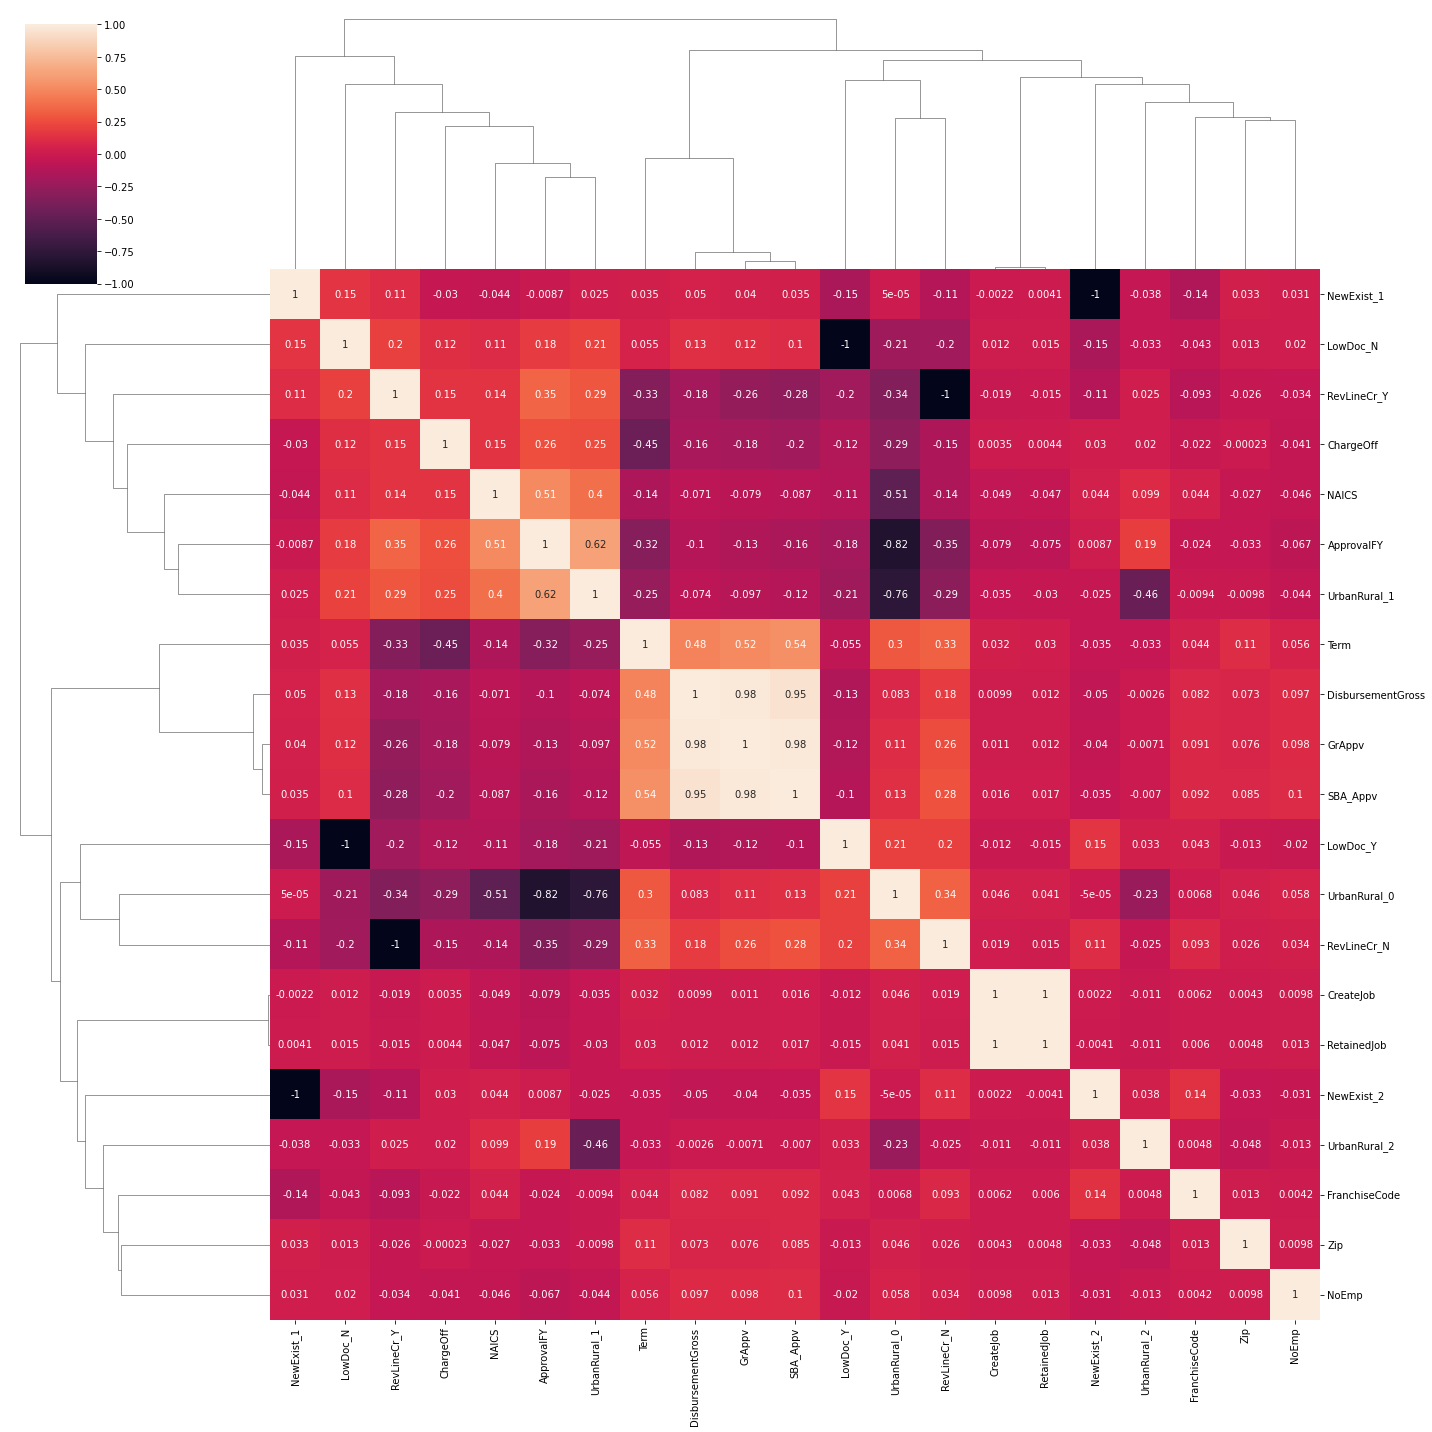

In [7]:
sb.clustermap(base_dropna.corr(), annot=True, figsize=(20, 20))

# Create Job and Retained Job is highly correlated 

# Low correlation
# ID, Create Job, Retained Job

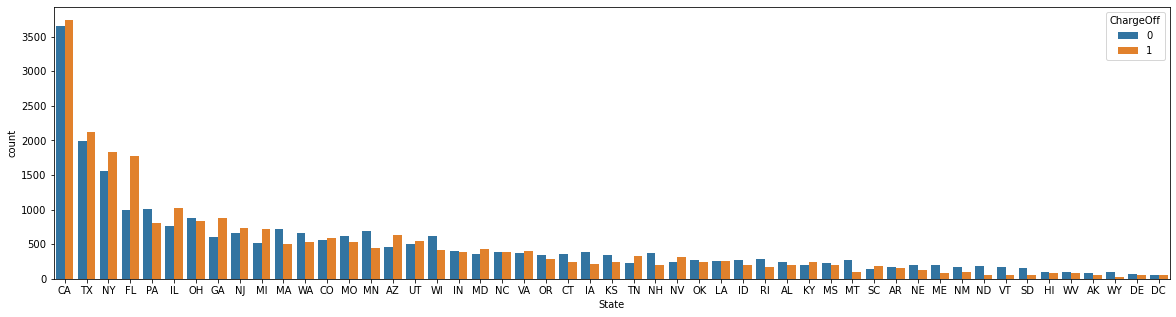

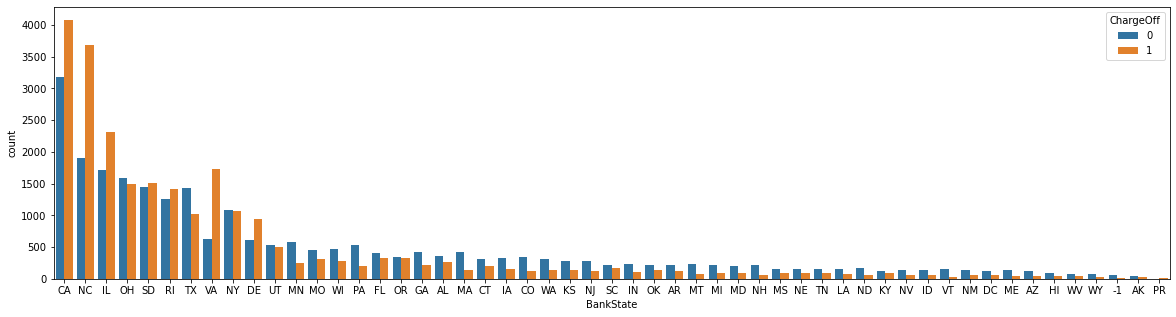

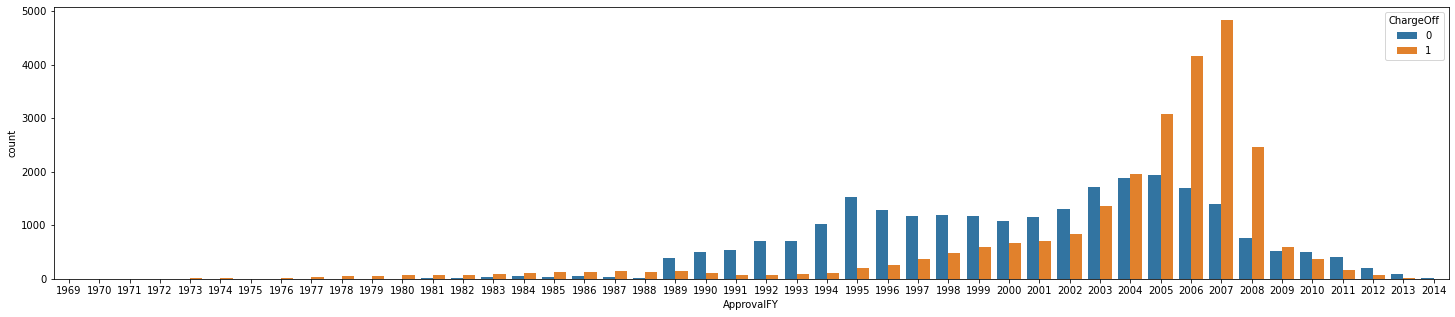

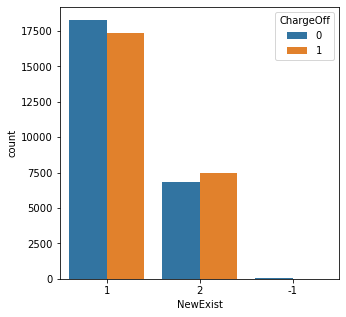

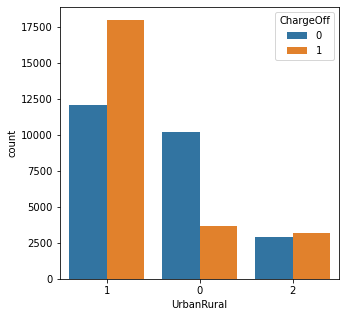

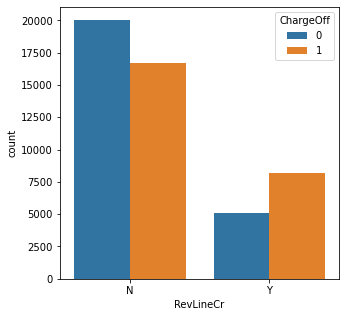

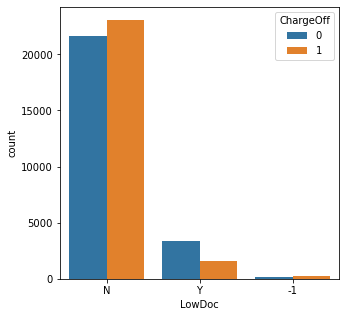

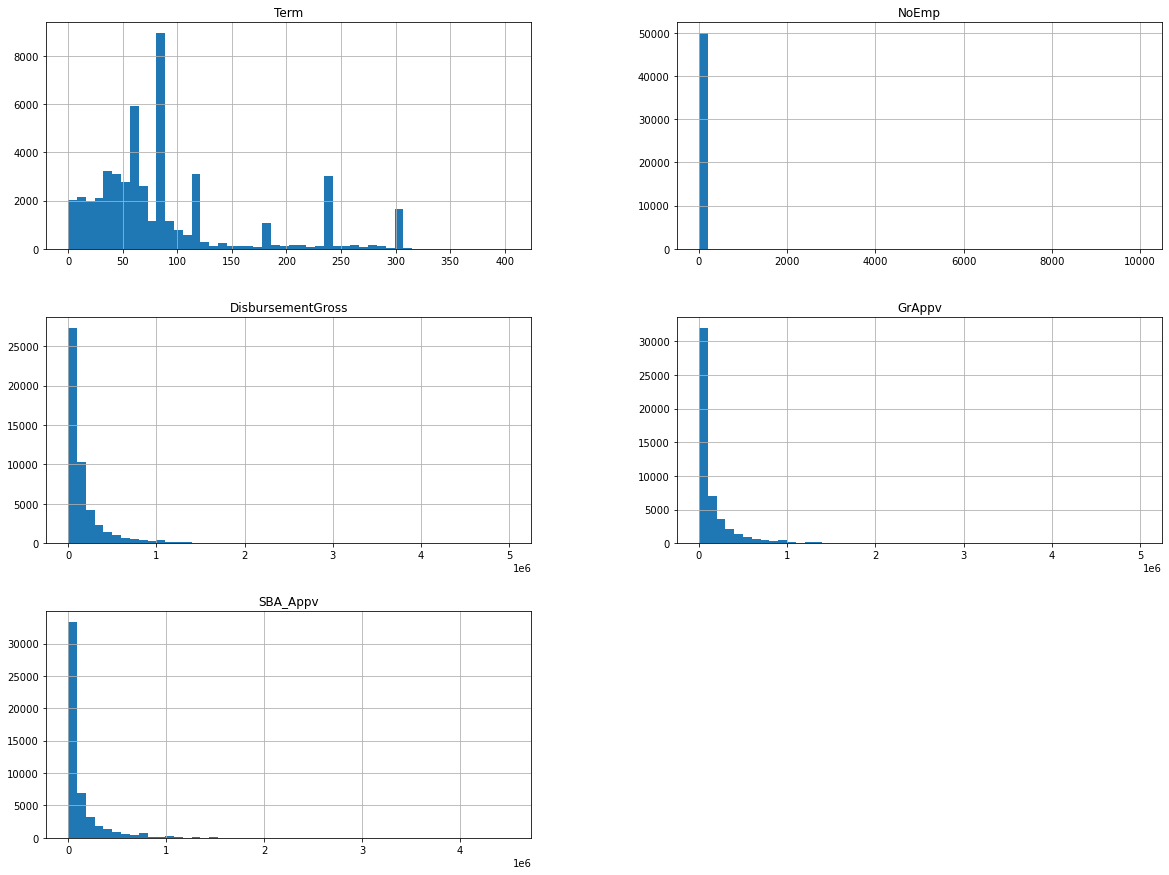

In [9]:
plt.figure(figsize=(20,5))
sb.countplot(x='State', data=df3,order = df3['State'].value_counts().index,hue='ChargeOff');

plt.figure(figsize=(20,5))
sb.countplot(x='BankState', data=df3,order = df3['BankState'].value_counts().index,hue='ChargeOff' );

plt.figure(figsize=(25,5))
sb.countplot(x='ApprovalFY', data=df3.sort_values(by='ApprovalFY'),hue='ChargeOff');

plt.figure(figsize=(5,5))
sb.countplot(x='NewExist', data=df3,order = df3['NewExist'].value_counts().index,hue='ChargeOff' );

plt.figure(figsize=(5,5))
sb.countplot(x='UrbanRural', data=df3,order = df3['UrbanRural'].value_counts().index,hue='ChargeOff' );

plt.figure(figsize=(5,5))
sb.countplot(x='RevLineCr', data=df3,order = df3['RevLineCr'].value_counts().index,hue='ChargeOff' );

plt.figure(figsize=(5,5))
sb.countplot(x='LowDoc', data=df3,order = df3['LowDoc'].value_counts().index,hue='ChargeOff' );

columns_for_plot=['Term','NoEmp','DisbursementGross','GrAppv','SBA_Appv']
df3.hist(bins=50,column = columns_for_plot,figsize=[20,15]);

# outliner for NoEmp

{'whiskers': [<matplotlib.lines.Line2D at 0x194fb8c6d48>,
 'caps': [<matplotlib.lines.Line2D at 0x194fb8c7d08>,
 'boxes': [<matplotlib.lines.Line2D at 0x194fb8c6b48>],
 'medians': [<matplotlib.lines.Line2D at 0x194fb8facc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x194fb8e8b48>],
 'means': []}

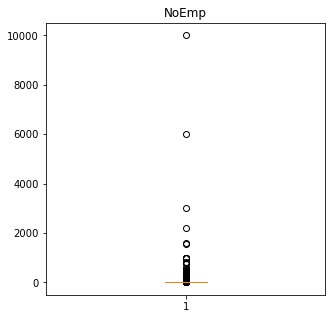

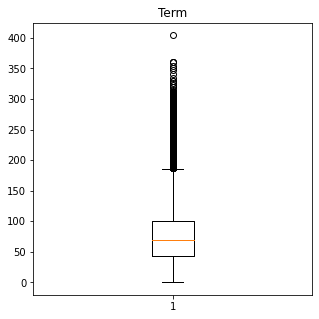

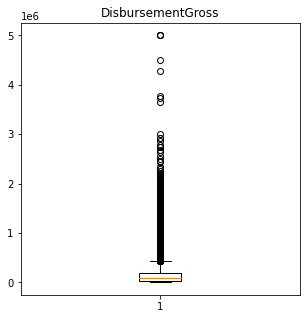

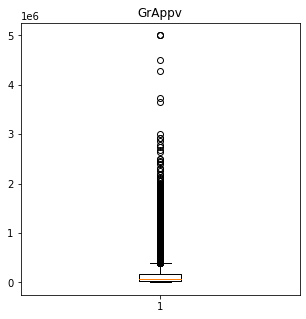

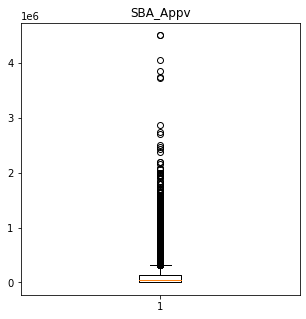

In [10]:
plt.figure(figsize=(5,5))
plt.title('NoEmp')
plt.boxplot(df3['NoEmp'])

plt.figure(figsize=(5,5))
plt.title('Term')
plt.boxplot(df3['Term'])

plt.figure(figsize=(5,5))
plt.title('DisbursementGross')
plt.boxplot(df3['DisbursementGross'])

plt.figure(figsize=(5,5))
plt.title('GrAppv')
plt.boxplot(df3['GrAppv'])

plt.figure(figsize=(5,5))
plt.title('SBA_Appv')
plt.boxplot(df3['SBA_Appv'])



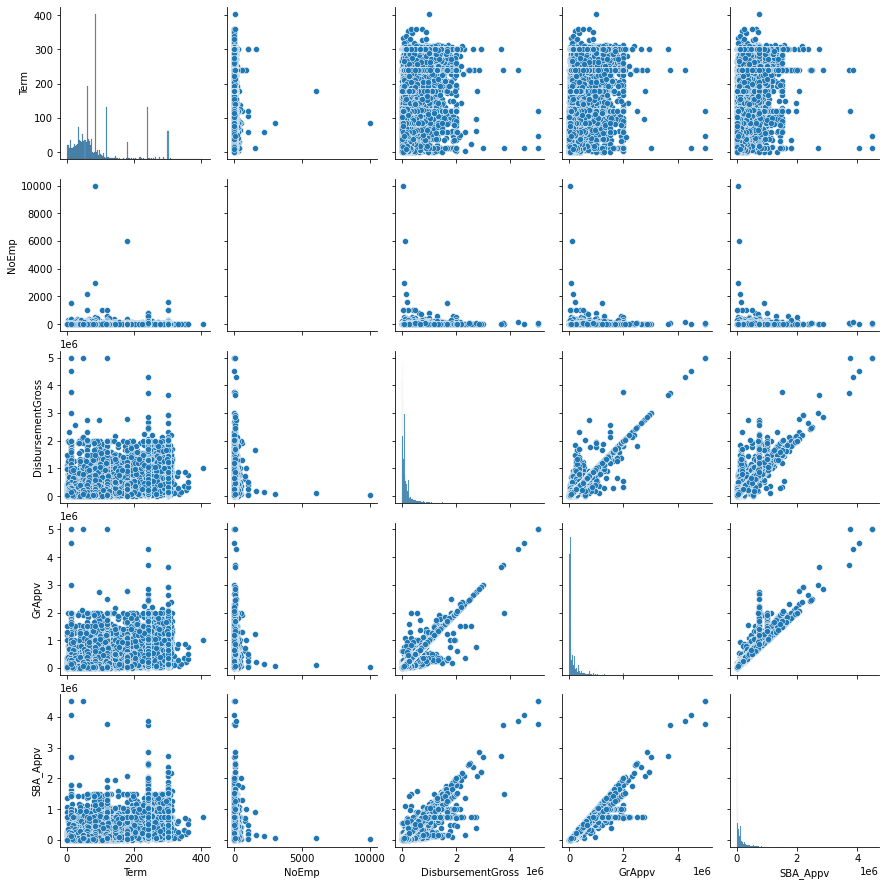

In [11]:
sb.pairplot(df3, vars=columns_for_plot)

In [12]:
model_names = ['KNN', 'LR', 'DT', 'RF', 'GBM']
base_dropna_f1 = []
base_dropna_acc = []
base_fillna_f1 = []
base_fillna_acc = []
feature_dropna_f1 = []
feature_dropna_acc = []
feature_fillna_f1 = []
feature_fillna_acc = []

def calculate_acc_and_f1(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    return f1, acc

    
def train_single_classifier(classifier, df_in, f1_list, acc_list):
    df_x = df_in.drop(columns='ChargeOff')
    df_y = df_in['ChargeOff']
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.25, random_state=0)
    f1, acc = calculate_acc_and_f1(classifier, x_train, y_train, x_test, y_test)
    f1_list.append(f1)
    acc_list.append(acc)
    

def train_model(df_in, f1_list, acc_list):
    df_numeric = df_in.drop(columns=['Name','City','State','Bank','BankState'])
    df_numeric['ApprovalDate'] = (df_numeric['ApprovalDate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    df_numeric['DisbursementDate'] = (df_numeric['DisbursementDate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    train_single_classifier(KNeighborsClassifier(), df_numeric, f1_list, acc_list)
    train_single_classifier(LogisticRegression(), df_numeric, f1_list, acc_list)
    train_single_classifier(DecisionTreeClassifier(), df_numeric, f1_list, acc_list)
    train_single_classifier(RandomForestClassifier(), df_numeric, f1_list, acc_list)
    train_single_classifier(GradientBoostingClassifier(), df_numeric, f1_list, acc_list)
    

train_model(base_dropna, base_dropna_f1, base_dropna_acc)
# train_model(base_fillna, base_fillna_f1, base_fillna_acc)
train_model(feature_dropna, feature_dropna_f1, feature_dropna_acc)
# train_model(feature_fillna, feature_fillna_f1, feature_fillna_acc)

In [13]:
# accuracy_record = pd.DataFrame({'Model': model_names, 'base_dropna_acc': base_dropna_acc, 'base_fillna_acc': base_fillna_acc, 'feature_dropna_acc': feature_dropna_acc, 'feature_fillna_acc': feature_fillna_acc})
accuracy_record = pd.DataFrame({'Model': model_names, 'base_dropna_acc': base_dropna_acc, 'feature_dropna_acc': feature_dropna_acc})
accuracy_record['acc_mean'] = accuracy_record.mean(axis=1).round(2)
accuracy_record.set_index('Model', inplace=True)
accuracy_record.loc['avg'] = accuracy_record.mean()

# F1_record = pd.DataFrame({'Model': model_names, 'base_dropna_f1': base_dropna_f1, 'base_fillna_f1': base_fillna_f1, 'feature_dropna_f1': feature_dropna_f1, 'feature_fillna_f1': feature_fillna_f1})
F1_record = pd.DataFrame({'Model': model_names, 'base_dropna_f1': base_dropna_f1, 'feature_dropna_f1': feature_dropna_f1})
F1_record['F1_mean'] = F1_record.mean(axis=1).round(2)
F1_record.set_index('Model', inplace=True)
F1_record.loc['avg'] = F1_record.mean()

print(accuracy_record)
print('\n')
print(F1_record)

       base_dropna_acc  feature_dropna_acc  acc_mean
Model                                               
KNN             68.200               68.20    68.200
LR              63.570               63.57    63.570
DT              88.030               70.87    79.450
RF              89.520               78.37    83.940
GBM             89.800               77.59    83.700
avg             79.824               71.72    75.772


       base_dropna_f1  feature_dropna_f1  F1_mean
Model                                            
KNN            68.200             68.200   68.200
LR             62.720             62.720   62.720
DT             88.030             70.870   79.450
RF             89.520             78.360   83.940
GBM            89.800             77.590   83.700
avg            79.654             71.548   75.602


In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])

list(le.classes_)

le.transform(["tokyo", "tokyo", "paris"])

list(le.inverse_transform([2, 2, 1]))

['tokyo', 'tokyo', 'paris']